In [187]:
import pandas as pd
from collections import defaultdict
import csv
from matplotlib import pyplot as plt
import seaborn as sns


**Đọc file clean data** 

In [188]:
df = pd.read_csv('data/clean data.csv')
df.head()

,link,top_blue,top_red,jung_blue,jung_red,mid_blue,mid_red,ad_blue,ad_red,support_blue,...,kda_sp_blue,kda_sp_red,gold_difference,turret_blue,turret_red,dragon_blue,dragon_red,blue_heralds,red_heralds,team_win
0,/match/las/1292816024,Kled,Malphite,Lillia,Olaf,Yasuo,Sylas,Zeri,Caitlyn,Milio,...,4.00,0.6,9038.0,0.0,3.0,0.0,1.0,2,0,blue
1,/match/vn/82488841,Ornn,Jax,Rengar,Kha'Zix,Katarina,Kassadin,Jinx,Kalista,Pyke,...,1.00,3.0,4860.0,0.0,3.0,0.0,2.0,2,0,red
2,/match/lan/1382606234,Milio,Jayce,Zeri,Zed,Ornn,Karthus,Kha'Zix,Kayn,Malzahar,...,3.00,1.0,4552.0,0.0,0.0,0.0,1.0,1,1,blue
3,/match/sg/6763657,Ornn,Udyr,Hecarim,Sylas,Fizz,Renekton,Samira,Vayne,Alistar,...,1.17,5.0,-608.0,0.0,0.0,1.0,1.0,1,0,blue
4,/match/eune/3359078179,Malphite,Mordekaiser,Zac,Gragas,LeBlanc,Tristana,Sivir,Jinx,Milio,...,0.00,6.0,-6015.0,2.0,0.0,1.0,0.0,0,2,red


**Thêm các cột chênh lệch về rồng, sứ giả, trụ phút thứ 15 và chênh lệch về kda (kil - death - assist) giữa các đường**

In [189]:
df["herald_difference"] = df["blue_heralds"] - df["red_heralds"]
df["dragon_difference"] = df["dragon_blue"] - df["dragon_red"]
df["turret_difference"] = df["turret_blue"] - df["turret_red"]

df["kda_difference_top"] = df["kda_top_blue"] - df["kda_top_red"]
df["kda_difference_jungle"] = df["kda_jungle_blue"] - df["kda_jungle_red"]
df["kda_difference_mid"] = df["kda_mid_blue"] - df["kda_mid_red"]
df["kda_difference_ad"] = df["kda_ad_blue"] - df["kda_ad_red"]
df["kda_difference_sp"] = df["kda_sp_blue"] - df["kda_sp_red"]

**Xóa những cột dư thừa sau khi tính chênh lệch**

In [190]:
df = df.drop(['kda_top_blue', 'kda_top_red', 'kda_jungle_blue', 'kda_jungle_red', 'kda_mid_blue', 'kda_mid_red', 
              'kda_ad_blue', 'kda_ad_red', 'kda_sp_blue', 'kda_sp_red', 'link','dragon_blue', 'dragon_red', 'turret_blue', 
              'turret_red', 'blue_heralds', 'red_heralds'], axis=1)
df.head()

,top_blue,top_red,jung_blue,jung_red,mid_blue,mid_red,ad_blue,ad_red,support_blue,support_red,gold_difference,team_win,herald_difference,dragon_difference,turret_difference,kda_difference_top,kda_difference_jungle,kda_difference_mid,kda_difference_ad,kda_difference_sp
0,Kled,Malphite,Lillia,Olaf,Yasuo,Sylas,Zeri,Caitlyn,Milio,Maokai,9038.0,blue,2,-1.0,-3.0,0.00,12.40,-3.0,11.67,3.40
1,Ornn,Jax,Rengar,Kha'Zix,Katarina,Kassadin,Jinx,Kalista,Pyke,Alistar,4860.0,red,2,-2.0,-3.0,2.83,0.50,-1.0,1.00,-2.00
2,Milio,Jayce,Zeri,Zed,Ornn,Karthus,Kha'Zix,Kayn,Malzahar,Zilean,4552.0,blue,0,-1.0,0.0,1.50,-0.17,1.0,0.67,2.00
3,Ornn,Udyr,Hecarim,Sylas,Fizz,Renekton,Samira,Vayne,Alistar,Blitzcrank,-608.0,blue,1,0.0,0.0,-1.50,0.57,1.0,-0.83,-3.83
4,Malphite,Mordekaiser,Zac,Gragas,LeBlanc,Tristana,Sivir,Jinx,Milio,Lulu,-6015.0,red,-2,1.0,2.0,2.00,-5.00,0.0,-5.50,-6.00


**Làm 1 dictionary về dữ liệu: tướng - vị trí đi đường - vai trò bằng data_champions.csv thu thập được**

In [191]:
# Đọc dữ liệu từ tệp data_champions.csv và tạo từ điển champions_dict
data_champions = pd.read_csv('data/data_champions.csv')
champions_dict = {}
for index, row in data_champions.iterrows():
    champion = row['Champions']
    lane = row['Lane']
    role = row['Role']
    if champion in champions_dict:
        champions_dict[champion]['Lane'].append(lane)
        champions_dict[champion]['Role'].append(role)
    else:
        champions_dict[champion] = {'Lane': [lane], 'Role': [role]}

**Thêm các cột phân loại tướng các đường dựa trên dictionary vừa tạo**

In [192]:
# Duyệt từng hàng trong data_done.csv
for index, row in df.iterrows():
    # Duyệt từng cột tên tướng và trích xuất thông tin về lane và role tương ứng
    for column in ['top_blue', 'top_red', 'jung_blue', 'jung_red', 'mid_blue', 'mid_red', 'ad_blue', 'ad_red', 'support_blue', 'support_red']:
        champion_name = row[column]
        if champion_name not in champions_dict:
            print(f"Warning: Champion {champion_name} not found in champions_dict")
            continue
        lanes = champions_dict[champion_name]['Lane']
        roles = champions_dict[champion_name]['Role']
        lane_col = f"{column}_lane"
        role_col = f"{column}_role"
        df.at[index, lane_col] = ','.join(lanes)
        df.at[index, role_col] = ','.join(roles)

**Lưu vào file data mới**

In [193]:
df.to_csv('data/data_fe.csv', index=False)

**Tính điểm đội hình dựa trên lane, role: nếu có các vị trí, vai trò chính và cần thiết thì +1.**
**Nếu đội hình bị sai/ thừa/ thiếu vị trí thì điểm sẽ thấp hơn những đội hình đầy đủ**

1. Đọc file data feature engineering

In [194]:
df = pd.read_csv("data/data_fe.csv")

2. Duyệt từng hàng, tính điểm cho từng đường và từng vị trí của 2 đội, sau đó cộng vào để lấy điểm tổng của cả 2 đội

In [195]:
# duyệt từng hàng của dataframe
for index, row in df.iterrows():
    score_blue = 0
    score_red = 0
    # kiểm tra lane của các vị trí của đội blue
    if row['top_blue_lane'] == 'top':
        score_blue += 1
    if row['jung_blue_lane'] == 'jungle':
        score_blue += 1
    if row['mid_blue_lane'] == 'mid':
        score_blue += 1
    if row['ad_blue_lane'] == 'adc':
        score_blue += 1
    if row['support_blue_lane'] == 'support':
        score_blue += 1
    # kiểm tra lane của các vị trí của đội red
    if row['top_red_lane'] == 'top':
        score_red += 1
    if row['jung_red_lane'] == 'jungle':
        score_red += 1
    if row['mid_red_lane'] == 'mid':
        score_red += 1
    if row['ad_red_lane'] == 'adc':
        score_red += 1
    if row['support_red_lane'] == 'support':
        score_red += 1
    df.loc[index, 'score_blue'] = score_blue
    df.loc[index, 'score_red'] = score_red

    score_blue_role = {'Marksman': 0, 'Fighter': 0, 'Tank': 0, 'Assassin': 0, 'Mage': 0, 'Support': 0}
    score_red_role = {'Marksman': 0, 'Fighter': 0, 'Tank': 0, 'Assassin': 0, 'Mage': 0, 'Support': 0}
    for position in ['top_blue_role', 'jung_blue_role', 'mid_blue_role', 'ad_blue_role', 'support_blue_role']:
        role = row[position]
        if role == 'Marksman':
            score_blue_role['Marksman'] = 1
        elif role == 'Fighter':
            score_blue_role['Fighter'] = 1
        elif role == 'Tank':
            score_blue_role['Tank'] = 1
        elif role == 'Assassin':
            score_blue_role['Assassin'] = 1
        elif role == 'Mage':
            score_blue_role['Mage'] = 1
        elif role == 'Support':
            score_blue_role['Support'] = 1
    # kiểm tra role của các vị trí của đội red
    for position in ['top_red_role', 'jung_red_role', 'mid_red_role', 'ad_red_role', 'support_red_role']:
        role = row[position]
        if role == 'Marksman':
            score_red_role['Marksman'] = 1
        elif role == 'Fighter':
            score_red_role['Fighter'] = 1
        elif role == 'Tank':
            score_red_role['Tank'] = 1
        elif role == 'Assassin':
            score_red_role['Assassin'] = 1
        elif role == 'Mage':
            score_red_role['Mage'] = 1
        elif role == 'Support':
            score_red_role['Support'] = 1
    # lưu score_blue_role, score_red_role vào 2 cột
    df.loc[index, 'score_blue_role'] = sum(score_blue_role.values())
    df.loc[index, 'score_red_role'] = sum(score_red_role.values())
    
df.head()

,top_blue,top_red,jung_blue,jung_red,mid_blue,mid_red,ad_blue,ad_red,support_blue,support_red,...,ad_red_lane,ad_red_role,support_blue_lane,support_blue_role,support_red_lane,support_red_role,score_blue,score_red,score_blue_role,score_red_role
0,Kled,Malphite,Lillia,Olaf,Yasuo,Sylas,Zeri,Caitlyn,Milio,Maokai,...,adc,Marksman,support,Support,top,Tank,4.0,2.0,3.0,4.0
1,Ornn,Jax,Rengar,Kha'Zix,Katarina,Kassadin,Jinx,Kalista,Pyke,Alistar,...,adc,Marksman,support,Support,support,Tank,4.0,5.0,4.0,4.0
2,Milio,Jayce,Zeri,Zed,Ornn,Karthus,Kha'Zix,Kayn,Malzahar,Zilean,...,top,Fighter,mid,Mage,mid,Support,0.0,1.0,5.0,4.0
3,Ornn,Udyr,Hecarim,Sylas,Fizz,Renekton,Samira,Vayne,Alistar,Blitzcrank,...,top,Marksman,support,Tank,support,Tank,5.0,2.0,4.0,4.0
4,Malphite,Mordekaiser,Zac,Gragas,LeBlanc,Tristana,Sivir,Jinx,Milio,Lulu,...,adc,Marksman,support,Support,support,Support,4.0,4.0,4.0,3.0


3. Lưu điểm vào file csv

In [196]:
df.to_csv('data/data_fe.csv', index=False)

4. Tính chênh lệch điểm giữa 2 đội 

In [197]:
df["score_lane"] = df["score_blue"] - df["score_red"]
df["score_role"] = df["score_blue_role"] - df["score_red_role"]
df.head()

,top_blue,top_red,jung_blue,jung_red,mid_blue,mid_red,ad_blue,ad_red,support_blue,support_red,...,support_blue_lane,support_blue_role,support_red_lane,support_red_role,score_blue,score_red,score_blue_role,score_red_role,score_lane,score_role
0,Kled,Malphite,Lillia,Olaf,Yasuo,Sylas,Zeri,Caitlyn,Milio,Maokai,...,support,Support,top,Tank,4.0,2.0,3.0,4.0,2.0,-1.0
1,Ornn,Jax,Rengar,Kha'Zix,Katarina,Kassadin,Jinx,Kalista,Pyke,Alistar,...,support,Support,support,Tank,4.0,5.0,4.0,4.0,-1.0,0.0
2,Milio,Jayce,Zeri,Zed,Ornn,Karthus,Kha'Zix,Kayn,Malzahar,Zilean,...,mid,Mage,mid,Support,0.0,1.0,5.0,4.0,-1.0,1.0
3,Ornn,Udyr,Hecarim,Sylas,Fizz,Renekton,Samira,Vayne,Alistar,Blitzcrank,...,support,Tank,support,Tank,5.0,2.0,4.0,4.0,3.0,0.0
4,Malphite,Mordekaiser,Zac,Gragas,LeBlanc,Tristana,Sivir,Jinx,Milio,Lulu,...,support,Support,support,Support,4.0,4.0,4.0,3.0,0.0,1.0


5. Xóa các cột dư thừa sau khi tính chênh lệch

In [198]:
df = df.drop(['top_blue_lane', 'top_red_lane', 'jung_blue_lane', 'jung_red_lane', 'mid_blue_lane', 'mid_red_lane', 'ad_blue_lane', 
              'ad_red_lane', 'support_blue_lane', 'support_red_lane', 'top_blue_role', 'top_red_role', 'jung_blue_role', 'jung_red_role', 
              'mid_blue_role', 'mid_red_role', 'ad_blue_role', 'ad_red_role', 'support_blue_role', 'support_red_role', 'score_blue'
              , 'score_red' ,'score_blue_role' , 'score_red_role'], axis=1)

df.head()

,top_blue,top_red,jung_blue,jung_red,mid_blue,mid_red,ad_blue,ad_red,support_blue,support_red,...,herald_difference,dragon_difference,turret_difference,kda_difference_top,kda_difference_jungle,kda_difference_mid,kda_difference_ad,kda_difference_sp,score_lane,score_role
0,Kled,Malphite,Lillia,Olaf,Yasuo,Sylas,Zeri,Caitlyn,Milio,Maokai,...,2,-1.0,-3.0,0.00,12.40,-3.0,11.67,3.40,2.0,-1.0
1,Ornn,Jax,Rengar,Kha'Zix,Katarina,Kassadin,Jinx,Kalista,Pyke,Alistar,...,2,-2.0,-3.0,2.83,0.50,-1.0,1.00,-2.00,-1.0,0.0
2,Milio,Jayce,Zeri,Zed,Ornn,Karthus,Kha'Zix,Kayn,Malzahar,Zilean,...,0,-1.0,0.0,1.50,-0.17,1.0,0.67,2.00,-1.0,1.0
3,Ornn,Udyr,Hecarim,Sylas,Fizz,Renekton,Samira,Vayne,Alistar,Blitzcrank,...,1,0.0,0.0,-1.50,0.57,1.0,-0.83,-3.83,3.0,0.0
4,Malphite,Mordekaiser,Zac,Gragas,LeBlanc,Tristana,Sivir,Jinx,Milio,Lulu,...,-2,1.0,2.0,2.00,-5.00,0.0,-5.50,-6.00,0.0,1.0


5. Lưu lại data vào data_fe.csv (data feature engineering)

In [199]:
df.to_csv("data/data_fe.csv", index=False)

**Chia 10k dữ liệu thành 10 file, mỗi file 1k**

In [200]:
df = pd.read_csv('data/data_fe.csv')

# Drop các cột bị dư thừa
df = df.drop(['top_blue', 'top_red', 'jung_blue', 'jung_red', 'mid_blue', 'mid_red', 'ad_blue', 'ad_red', 'support_blue', 'support_red'], axis=1)

# Chuyển đổi team thắng sang 0 1 để dùng model dự đoán
df['team_win'] = df['team_win'].replace({'blue': 1, 'red': 0})

# Lưu dữ liệu trộn vào file CSV
df.to_csv('data/data_fe.csv', index=False)

In [201]:
for i in range(10):
    start_index = i * 1000
    end_index = start_index + 1000
    df_subset = df.iloc[start_index:end_index, :]
    filename = f"data/data extracted/data_fe_1000_part_{i+1}.csv"
    df_subset.to_csv(filename, index=False)

**Viết thêm 1 bộ dữ liệu có xử lý ngoại lệ để so sánh và lựa chọn**

*Vẽ phân bố của chênh lệch phút 15 trước khi xử lý ngoại lệ*

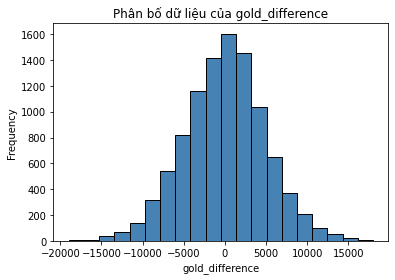

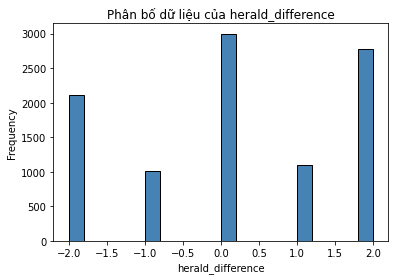

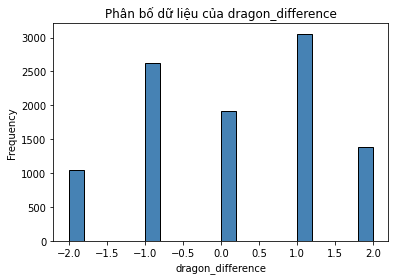

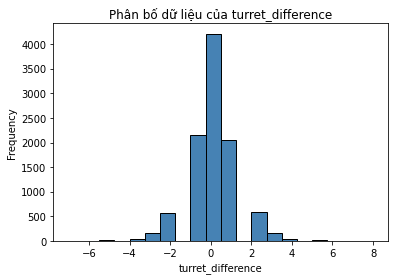

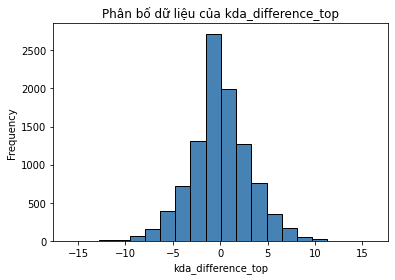

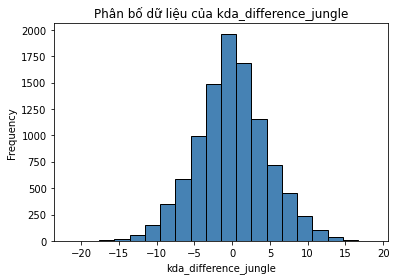

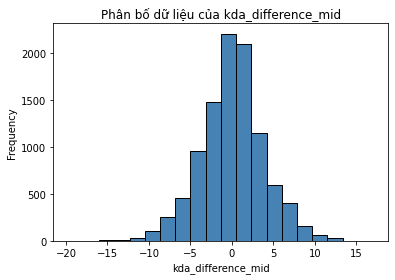

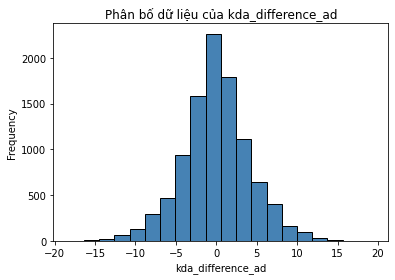

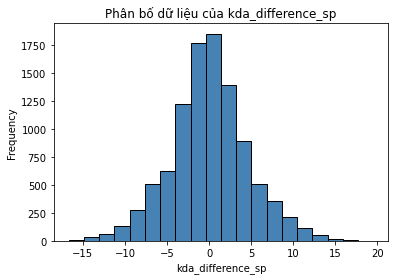

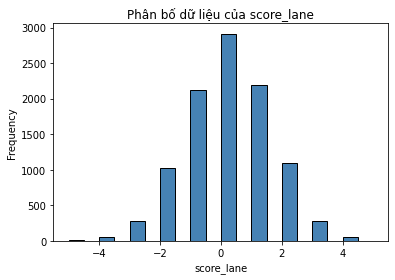

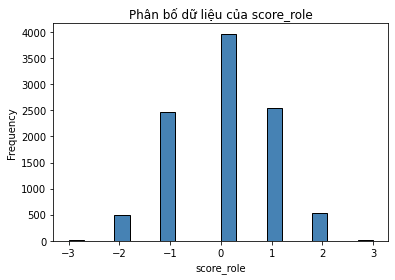

In [202]:
# Đọc dữ liệu từ file csv vào DataFrame
df = pd.read_csv("data/data_fe.csv")

# Tạo danh sách các cột ngoài cột "team_win"
columns_to_plot = [col for col in df.columns if col != "team_win"]

# Vòng lặp để vẽ histogram cho các cột
for column in columns_to_plot:
    plt.hist(df[column], bins=20, color='steelblue', edgecolor='black')
    plt.title(f"Phân bố dữ liệu của {column}")
    plt.xlabel(column)
    plt.ylabel("Frequency")
    plt.show()

*Vẽ phân bố và chênh lệch sau khi xử lý ngoại lệ*

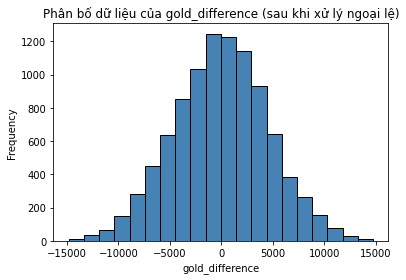

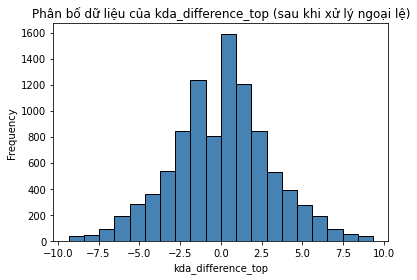

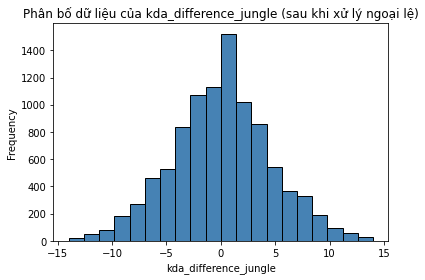

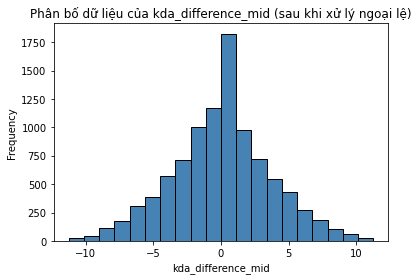

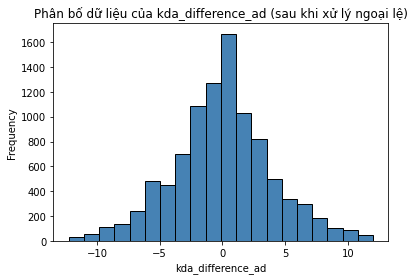

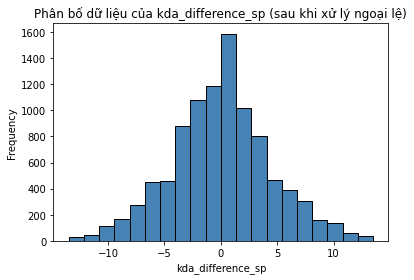

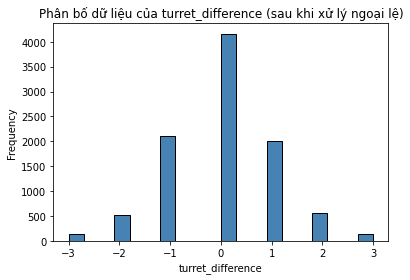

In [203]:
# Các cột cần xử lý ngoại lệ
columns = ['gold_difference', 'kda_difference_top', 'kda_difference_jungle', 'kda_difference_mid',
           'kda_difference_ad', 'kda_difference_sp', 'turret_difference']

# Xử lý ngoại lệ cho từng cột
for column in columns:
    # Lấy cột
    col = df[column]
    
    # Tính toán giá trị trung bình và độ lệch chuẩn
    mean = col.mean()
    std = col.std()
    
    # Định nghĩa giới hạn trên và dưới dựa trên độ lệch chuẩn (ví dụ: 3 độ lệch chuẩn)
    threshold = 3
    lower_bound = mean - (threshold * std)
    upper_bound = mean + (threshold * std)
    
    # Loại bỏ các giá trị ngoại lệ
    df = df[(col >= lower_bound) & (col <= upper_bound)]

# Lưu DataFrame mới vào file CSV
df.to_csv("data/data_fe_cleaned.csv", index=False)

# Vẽ biểu đồ phân bố dữ liệu sau khi xử lý ngoại lệ
for column in columns:
    plt.hist(df[column], bins=20, color='steelblue', edgecolor='black')
    plt.title(f"Phân bố dữ liệu của {column} (sau khi xử lý ngoại lệ)")
    plt.xlabel(column)
    plt.ylabel("Frequency")
    plt.show()

**Đọc lại file data**

In [204]:
df = pd.read_csv("data/data_fe.csv")

**Trực quan hóa dữ liệu sau khi xử lý đặc trưng**

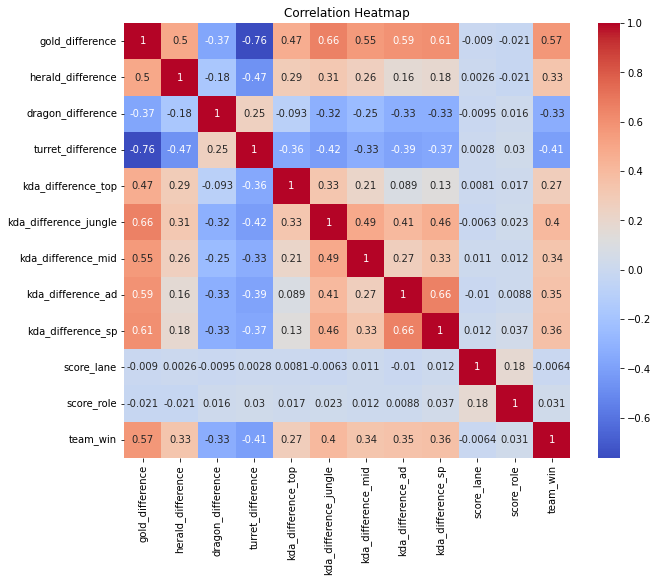

In [205]:
# Lựa chọn các cột quan tâm
columns_of_interest = ['gold_difference', 'herald_difference', 'dragon_difference', 'turret_difference',
                       'kda_difference_top', 'kda_difference_jungle', 'kda_difference_mid', 'kda_difference_ad',
                       'kda_difference_sp', 'score_lane', 'score_role', 'team_win']

# Tạo DataFrame mới với các cột quan tâm
df_selected = df[columns_of_interest]

# Tính ma trận tương quan
correlation_matrix = df_selected.corr()

# Vẽ heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

***Nhận xét:***
1. *Gold difference có ảnh hưởng lớn nhất đến biến mục tiêu (0.57)*
2. *Các đặc trưng có ảnh hưởng lớn đến biến mục tiêu bao gồm: gold difference (chênh lêch vàng), herald difference (chênh lệch sứ giả), kda của các đường*
3. *Những đặc trưng còn lại ảnh hưởng ít hoặc rất ít đến biến mục tiêu*

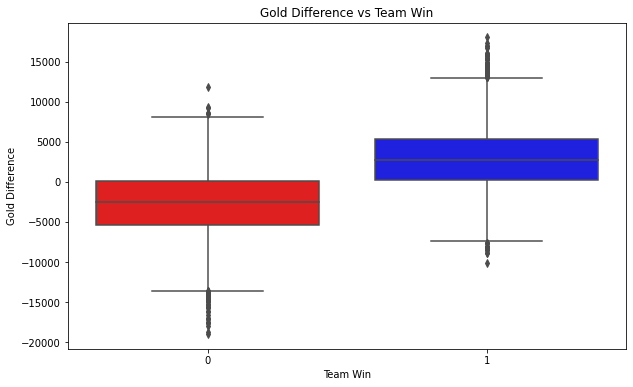

In [206]:
# Boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(x='team_win', y='gold_difference', data=df, palette=['red', 'blue'])
plt.title('Gold Difference vs Team Win')
plt.xlabel('Team Win')
plt.ylabel('Gold Difference')
plt.show()

***Nhận xét:***
1. *Boxplot cho thấy sự ảnh hưởng của chênh lệch vàng đến biến mục tiêu (chênh lệch vàng càng lớn thì khả năng thắng của team xanh càng cao và ngược lại)*
2. *Chênh lệch vàng vào phút 15 phân bố chủ yếu từ -5k đến 5k, có 1 số trận đấu có chênh lệch lớn hơn, tuy nhiên không đáng kể*

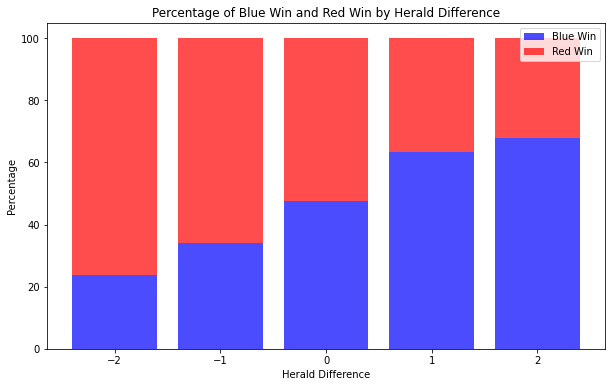

In [207]:
# Lọc các trận đấu có herald_difference là -2, -1, 0, 1, 2
filtered_df = df[df['herald_difference'].isin([-2, -1, 0, 1, 2])]

# Tính số trận đấu theo herald_difference và team_win
herald_counts = filtered_df.groupby('herald_difference')['team_win'].value_counts().unstack()

# Trích xuất số trận blue win
blue_win_counts = herald_counts[1].fillna(0)

# Tính phần trăm số trận blue win theo herald_difference
blue_win_percentage = (blue_win_counts / herald_counts.sum(axis=1)) * 100

# Tính phần trăm số trận red win theo herald_difference
red_win_percentage = 100 - blue_win_percentage

# Vẽ biểu đồ chồng
plt.figure(figsize=(10, 6))
plt.bar(herald_counts.index, blue_win_percentage, label='Blue Win', color='blue', alpha = 0.7)
plt.bar(herald_counts.index, red_win_percentage, bottom=blue_win_percentage, label='Red Win', color='red', alpha = 0.7)
plt.xlabel('Herald Difference')
plt.ylabel('Percentage')
plt.title('Percentage of Blue Win and Red Win by Herald Difference')
plt.legend()
plt.show()


***Nhận xét:***
1. *Chênh lệch bằng 0 thì tỉ lệ thắng của 2 team khá cân đối, nếu lớn hơn 0 thì thiên về team xanh (khoảng 60-70%), lớn hơn càng nhiều thì khả năng team xanh thắng càng lớn và ngược lại*
2. *Vẫn có 1 tỉ lệ tương đối lớn là có thể lật kèo sau phút 15, bởi nếu chênh lệch 1 đến 2 con sứ giả thì tỉ lệ thắng cũng chỉ nhỉnh hơn khoảng 10-20%*

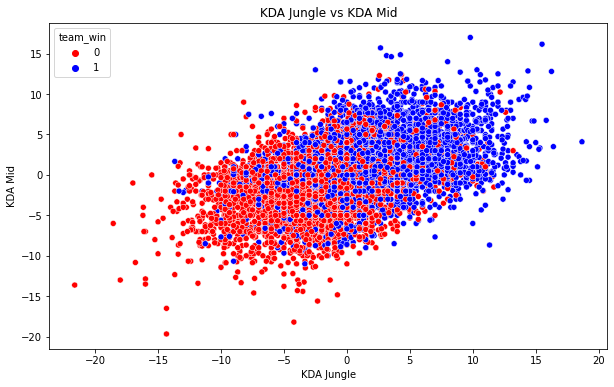

In [208]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='kda_difference_jungle', y='kda_difference_mid', hue='team_win', data=df, palette={0: 'red', 1: 'blue'})
plt.title('KDA Jungle vs KDA Mid')
plt.xlabel('KDA Jungle')
plt.ylabel('KDA Mid')
plt.show()


***Nhận xét:***
1. *Kda của rừng và đường giữa có 1 sự ảnh hưởng nhất định đối với nhau, kda rừng thấp thì có khả năng khá lớn là kda của đường giữa cũng sẽ thấp theo và ngược lại*
2. *Kda của rừng và đường giữa có tác động khá lớn đến kết quả trận đấu: nếu kda cả 2 cùng thấp thì tỉ lệ thua của trận đấu là khá lớn và ngược lại, tuy nhiên vẫn có khả năng lật kèo*

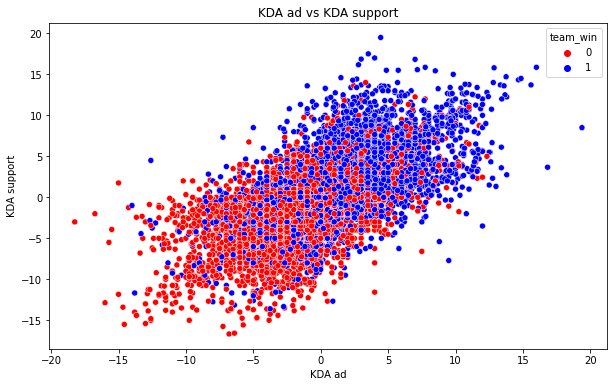

In [209]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='kda_difference_ad', y='kda_difference_sp', hue='team_win', data=df, palette={0: 'red', 1: 'blue'})
plt.title('KDA ad vs KDA support')
plt.xlabel('KDA ad')
plt.ylabel('KDA support')
plt.show()

***Nhận xét:***
1. *Kda ad và support có mối liên hệ lớn với nhau: nếu kda ad thấp thì khả năng cao là support cũng thấp và ngược lại*
2. *Kda ad và support có ảnh hưởng lớn đến kết quả chung của trận đấu: kda ad và support càng thấp thì tỉ lệ thua của trận đấu càng lớn và ngược lại*